In [10]:
PROCESSES_COUNT = 20

print("Importing...")
from multiprocessing import Pool

import importlib
import os
import sys
TOOLS_PATH = f"{os.getenv('MASTER_PROJECT_ROOT_FOLDER')}/logistics"
sys.path.insert(0, TOOLS_PATH)
from tools import run_tools, plot_tools, data_tools, endf_tools, komodo_tools
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# from progressbar import progressbar
from tqdm import tqdm
from uncertainties import ufloat

importlib.reload(komodo_tools)

results = []

result_folders = run_tools.get_all_result_dirs()
print(f"Found {len(result_folders)} result folders")

def handle_folder(result_folder):
    result_path = f"../results/{result_folder}"
    run_settings = run_tools.load_run_settings_json(result_path)

    komodo_input_file = run_settings["komodo_input_file"]

    result = { 
        "result_path": result_path,
        "komodo_output_path": f"{result_path}/{komodo_input_file}.out",
        "komodo_3d_power_output_path": f"{result_path}/{komodo_input_file}_3d_power.out",
    }

    # Load the KOMODO result
    komodo_result = komodo_tools.get_komodo_result(result_path, komodo_input_file, do_print_on_failed=False)
    if komodo_result is None:
        return None

    result.update(run_settings)
    result.update(komodo_result)
    
    return result

print(f"Loading data with {PROCESSES_COUNT} processes...")
with Pool(PROCESSES_COUNT) as p:
    # Loop over each run number and get the run settings as well as the k-effective
    # for result_folder in tqdm(result_folders):
    results = list(tqdm(p.imap(handle_folder, result_folders), total=len(result_folders)))

# Remove any results that failed
# First print the number of failed results
print(f"Not including failed results. Failed {len([result for result in results if result is None])} results.")
results = [result for result in results if result is not None]


Importing...
Found 272 result folders
Loading data with 20 processes...


100%|██████████| 272/272 [00:00<00:00, 2626.84it/s]


Not including failed results. Failed 0 results.


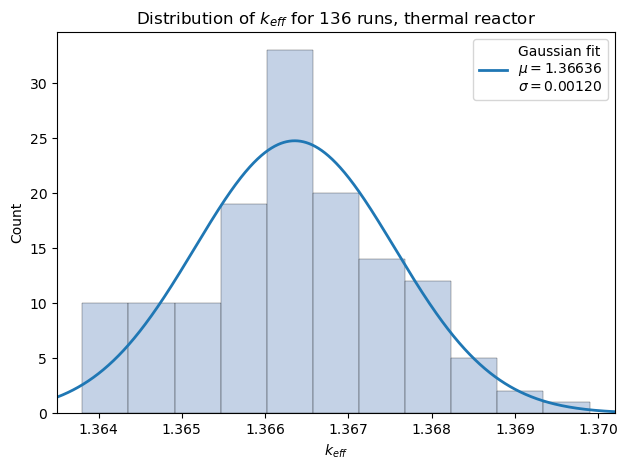

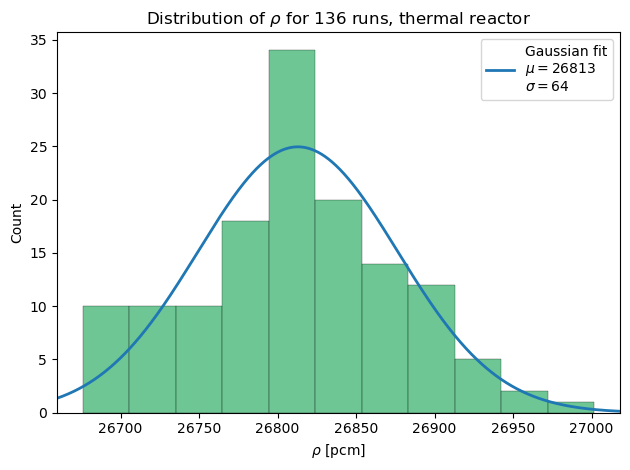

In [11]:
importlib.reload(plot_tools)
importlib.reload(data_tools)
importlib.reload(komodo_tools)

# PLOT SETTINGS:
for FAST_REACTOR in [True, False]:
    plt.close("all")

    NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"

    folder_name = f"plots-{NEUTRON_TEMP}"
    os.makedirs(folder_name, exist_ok=True)

    def get_filename(plot_type: str, value: str):
        return f"{folder_name}/{plot_type}_{value}-{NEUTRON_TEMP}.pdf"

    # Create a dataframe from the results
    df = pd.DataFrame(results)

    # Filters
    df = df[df["fast_reactor"] == FAST_REACTOR]

    if df.empty:
        print(f"WARN: No results found for {NEUTRON_TEMP} reactor")
        break

    df = data_tools.add_reactivity_to_df(df, include_std=False)

    plt.figure()
    fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="k-eff", 
                                            fit_gaussian=True, decimals=5,
                                            title=f"Distribution of $k_{{eff}}$ for {len(df)} runs, {NEUTRON_TEMP.lower()} reactor", x_label="$k_{eff}$", y_label="Count",
                                            filename=get_filename("heatmap", "distribution-k_eff"))

    plt.figure()
    fig, popt, pcov = plot_tools.plot_histogram_from_df(df=df, data_key="rho-pcm", color="mediumseagreen",
                                            fit_gaussian=True, decimals=0,
                                            title=fr"Distribution of $\rho$ for {len(df)} runs, {NEUTRON_TEMP.lower()} reactor", x_label=r"$\rho$ [pcm]", y_label="Count",
                                            filename=get_filename("heatmap", "distribution-rho"))

EPITHERMAL
Loading data with 20 processes...


100%|██████████| 136/136 [00:00<00:00, 382.57it/s]


THERMAL
Loading data with 20 processes...


100%|██████████| 136/136 [00:00<00:00, 395.43it/s]


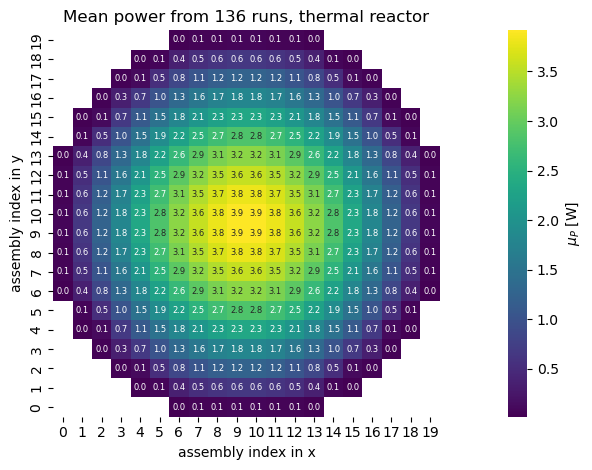

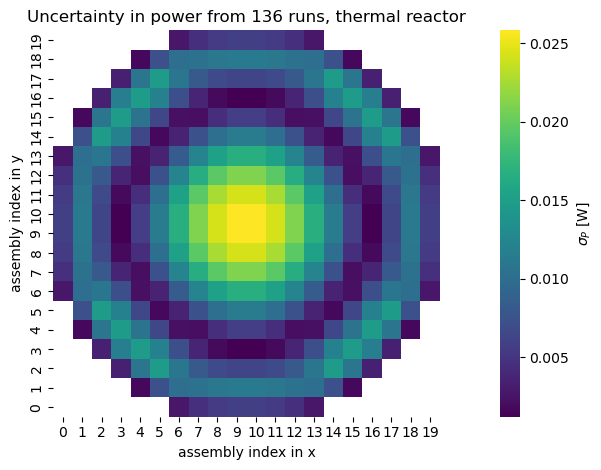

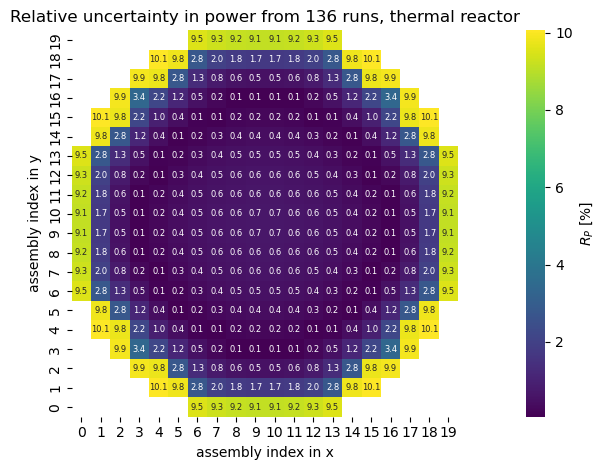

In [12]:
importlib.reload(plot_tools)
importlib.reload(data_tools)
importlib.reload(komodo_tools)

# Get the power distribution heatmaps and its uncertainty
for FAST_REACTOR in [True, False]:
    plt.close("all")

    NEUTRON_TEMP = "EPITHERMAL" if FAST_REACTOR else "THERMAL"
    print(NEUTRON_TEMP)

    folder_name = f"plots-{NEUTRON_TEMP}"
    os.makedirs(folder_name, exist_ok=True)

    def get_filename(plot_type: str, value: str):
        return f"{folder_name}/{plot_type}_{value}-{NEUTRON_TEMP}.pdf"

    # Create a dataframe from the results
    df = pd.DataFrame(results)

    # Filters
    df = df[df["fast_reactor"] == FAST_REACTOR]

    if df.empty:
        print(f"WARN: No results found for {NEUTRON_TEMP} reactor")
        break

    df = data_tools.add_reactivity_to_df(df, include_std=False)

    # Loop over each run and get the power from the power output file

    # for index, row in tqdm(df.iterrows(), total=len(df)):
    def handle_power_result(args):
        _, row = args
        komodo_3d_power_output_path = row["komodo_3d_power_output_path"]
        sum_power_profiles, power_profiles = komodo_tools.get_komodo_radial_power_results_in_quarter(komodo_3d_power_output_path)

        return (sum_power_profiles, power_profiles)

    print(f"Loading data with {PROCESSES_COUNT} processes...")
    with Pool(PROCESSES_COUNT) as p:
        power_results = list(tqdm(p.imap(handle_power_result, df.iterrows()), total=len(df)))

    power_profiles_list = np.array([power_profile for _, power_profile in power_results])
    sum_power_profiles_list = np.array([sum_power_profile for sum_power_profile, _ in power_results])

    # for idx, power_profile in enumerate(power_profiles_list[0]):
    #     print(f"Power profile {22-idx}:")
    #     for row in power_profile[10:]:
    #         for col in row[10:]:
    #             print(f"{str(col):>4}", end=" ")
    #         print()

    # break
        
    # Plot the mean, std and relative std of the sum of the power profiles
    mean_sum_power_profiles = np.mean(sum_power_profiles_list, axis=0)
    std_sum_power_profiles = np.std(sum_power_profiles_list, axis=0)
    rel_std_sum_power_profiles = std_sum_power_profiles / mean_sum_power_profiles

    plt.figure(1)
    plot_tools.plot_2d_heatmap_from_array(mean_sum_power_profiles, f"Mean power from {len(df)} runs, {NEUTRON_TEMP.lower()} reactor",
                                        "assembly index in x", "assembly index in y", annot=True, fmt=".1f", square=True,
                                        filename = get_filename("heatmap", "mean-power-2d-heatmap"),
                                        cbar_label=r"$\mu_P$ [W]")

    plt.figure(2)
    plot_tools.plot_2d_heatmap_from_array(std_sum_power_profiles, f"Uncertainty in power from {len(df)} runs, {NEUTRON_TEMP.lower()} reactor",
                                        "assembly index in x", "assembly index in y", annot=False, square=True,
                                        filename = get_filename("heatmap", "std-power-2d-heatmap"),
                                        cbar_label=r"$\sigma_P$ [W]")

    plt.figure(3)
    plot_tools.plot_2d_heatmap_from_array(100*rel_std_sum_power_profiles, f"Relative uncertainty in power from {len(df)} runs, {NEUTRON_TEMP.lower()} reactor",
                                        "assembly index in x", "assembly index in y", annot=True, fmt=".1f", square=True,
                                        filename = get_filename("heatmap", "rel-std-power-2d-heatmap"),
                                        cbar_label=r"$R_P$ [%]")
    
